# Factor Analysis using the CAPM and Fama-French Factor Model

The main idea in Factor Analysis is to take a set of observed returns and decompose it into a set of explanatory returns

In [37]:
# used during development to releoad modules every time there is a change
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import statsmodels.api as sm
from course_1.risk_kit import Metrics, pre_processing_hfi, \
pre_processing_ind, get_ind30_nfirms, \
get_ind30_size, plot_ef2, get_fff_returns, \
get_ind_market_caps, get_ind30_nfirms, weight_ew, weight_cw, \
weight_ew_cap_teth

from data_prep import get_ind_returns, get_ind_returns2, get_ind_market_caps

import ipywidgets as widgets
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.options.display.float_format = '{:.6f}'.format

m= Metrics()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
brka_d =pd.read_csv("data/brka_d_ret.csv", parse_dates=True, index_col=0)
brka_d.head(), brka_d.tail()
brka_d.shape

(                BRKA
 DATE                
 1990-01-02 -0.005764
 1990-01-03  0.000000
 1990-01-04  0.005797
 1990-01-05 -0.005764
 1990-01-08  0.000000,
                 BRKA
 DATE                
 2018-12-24 -0.018611
 2018-12-26  0.043200
 2018-12-27  0.012379
 2018-12-28  0.013735
 2018-12-31  0.011236)

(7307, 1)

let's convert these to monthly returns

In [3]:
brka_m = brka_d.resample("M").apply(m.compound).to_period("M")
brka_m.to_csv("brka_m.csv") # for future use

In [4]:
# let's load the explanatory variables (Fama-French monthly return dataset)
fff = get_fff_returns()
fff.head()

,Mkt-RF,SMB,HML,RF
1926-07,0.029600,-0.023000,-0.028700,0.002200
1926-08,0.026400,-0.014000,0.041900,0.002500
1926-09,0.003600,-0.013200,0.000100,0.002300
1926-10,-0.032400,0.000400,0.005100,0.003200
1926-11,0.025300,-0.002000,-0.003500,0.003100


Mkt-RF is the excess return from the market on top o the risk free rate (RF)
SMB (Small minus Big): it is only the excess return of the size (it is a long short portfolio so
it shouldn't have the marker return in it).

HML (High minus Low): it is the Value - Growth (it is a long-short portfolio)

### we need to take our real returns and try to figure out a possibile split of these returns among the factors 
$$ R_{brka,t} - R_{f,t} = \alpha + \beta(R_{mkt,t} - R_{f,t}) + \epsilon_t $$

In [5]:
# let's use the CAPM model
brka_excess = brka_m["1990": "2012-05"] - fff.loc["1990": "2012-05" , ["RF"]].values
mkt_excess =  fff.loc["1990": "2012-05" , ["Mkt-RF"]]
exp_var = mkt_excess.copy()
exp_var["Constant"] = 1
lm = sm.OLS(brka_excess, exp_var).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     48.45
Date:                Thu, 12 Oct 2023   Prob (F-statistic):           2.62e-11
Time:                        16:02:40   Log-Likelihood:                 388.47
No. Observations:                 269   AIC:                            -772.9
Df Residuals:                     267   BIC:                            -765.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.5402      0.078      6.961      0.000       0.387       0.693
Constant       0.0061      0.004      1.744      0.082      -0.001       0.013
==============================================================================
Omnibus:                       45.698   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.573
Skew:                           0.825   Prob(JB):                     5.33e-23
Kurtosis:                       5.535   Cond. No.                         22.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

COMMENT: 
Constant is alpha: 61 basis point/month (not bad!)

beta is 0.54.

The CAPM benchmark implies that each dollar in the portfolio consists of 46 cents in T-Bills and 54 cents in the market. Relative to this the asset manager is adding 61 cents (alpha) per month! Note however that the p-value is significant at 10% level confidence. (Not very high statistically significance)

In [6]:
# let's use the Fama-French model
exp_var["Value"] =  fff.loc["1990": "2012-05" , ["HML"]]
exp_var["Size"] =  fff.loc["1990": "2012-05" , ["SMB"]]
exp_var.head()

,Mkt-RF,Constant,Value,Size
1990-01,-0.078500,1,0.008700,-0.012900
1990-02,0.011100,1,0.006100,0.010300
1990-03,0.018300,1,-0.029000,0.015200
1990-04,-0.033600,1,-0.025500,-0.005000
1990-05,0.084200,1,-0.037400,-0.025700


In [7]:
lm = sm.OLS(brka_excess, exp_var).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     36.06
Date:                Thu, 12 Oct 2023   Prob (F-statistic):           1.41e-19
Time:                        16:02:40   Log-Likelihood:                 412.09
No. Observations:                 269   AIC:                            -816.2
Df Residuals:                     265   BIC:                            -801.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.6761      0.074      9.155      0.000       0.531       0.821
Constant       0.0055      0.003      1.679      0.094      -0.001       0.012
Value          0.3814      0.109      3.508      0.001       0.167       0.595
Size          -0.5023      0.101     -4.962      0.000      -0.702      -0.303
==============================================================================
Omnibus:                       42.261   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.954
Skew:                           0.904   Prob(JB):                     1.75e-15
Kurtosis:                       4.671   Cond. No.                         37.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

COMMENT: 

Constant is alpha: 55 basis point/month (reduced from 61)

beta is 0.67 (the loading on the market moved up. This implies that we added significant factors)

Value is 0.38 (portfolio is value tilted)

Size is -0.5: the portfolio tilted towards large stocks rather than mid stocks (the asset manager
tended to invest in large companies)

The Fama-French benchmark implies that each dollar in the portfolio consists of 33 cents in T-Bills and 67 cents in the market. Relative to this the asset manager is adding 55 basis points (alpha) per month! Note however that the p-value is significant at 10% confidence level. (Not very high statistically significance)
The new way to interpret each dollar invested in Hathaway is: 67 cents in the market, 33 cents in Bills, 38 cents in Value stocks and short 38 cents in Growth stocks, short 50 cents in SmallCap stocks and long 50 cents in LargeCap stocks. If you did all this, you would still end up underperforming Hathaway by about 55 basis points per month.

In [8]:
m.regress(brka_excess, exp_var, alpha=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     36.06
Date:                Thu, 12 Oct 2023   Prob (F-statistic):           1.41e-19
Time:                        16:02:40   Log-Likelihood:                 412.09
No. Observations:                 269   AIC:                            -816.2
Df Residuals:                     265   BIC:                            -801.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.6761      0.074      9.155      0.000       0.531       0.821
Constant       0.0055      0.003      1.679      0.094      -0.001       0.012
Value          0.3814      0.109      3.508      0.001       0.167       0.595
Size          -0.5023      0.101     -4.962      0.000      -0.702      -0.303
==============================================================================
Omnibus:                       42.261   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.954
Skew:                           0.904   Prob(JB):                     1.75e-15
Kurtosis:                       4.671   Cond. No.                         37.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Sharpe Style Analysis

Sharpe Style Analysis is an elegant and simple decomposition exercise similar to what we did in the previous lab session, with the added constraint that the coefficients are all positive and add to 1.

Therefore, the coefficients of performing style analysis on the observed return of a manager can be interpreted as weights in a portfolio of building blocks which together, _mimic_ that return series. The exercise can reveal drifts in a manager's style as well as provide insight into what the manager is likely doing to obtain the returns.


# Performing Sharpe Style Analysis

The key to obtaining the weights is our old friend, the quadriatic optimizer. We are asking the optimizer to find the weights that minimizes the square of the difference between the observed series and the returns of a benchmark portfolio that holds the explanatory building blocks in those same weights. This is equivalent to minimizing the _tracking error_ between the two return series.

In [9]:
ind = get_ind_returns()["2000":]

In [10]:
# Let's construct a manager that invests in 30% Beer, 50% in Smoke and 20% 
# in other things that have an average return of 0% and an annualized vol of 15%

mgr_r = 0.3*ind["Beer"] + 0.5*ind["Smoke"] + 0.2*np.random.normal(scale=0.15/(12**.5), size=ind.shape[0])

In [11]:
# Now, assume we knew absolutely nothing about this manager and all we observed was the returns. 
# we don't know anything about the previous formula. Just the returns (observed variable)
# How could we tell what she was invested in?
weights = m.style_analysis(mgr_r, ind)

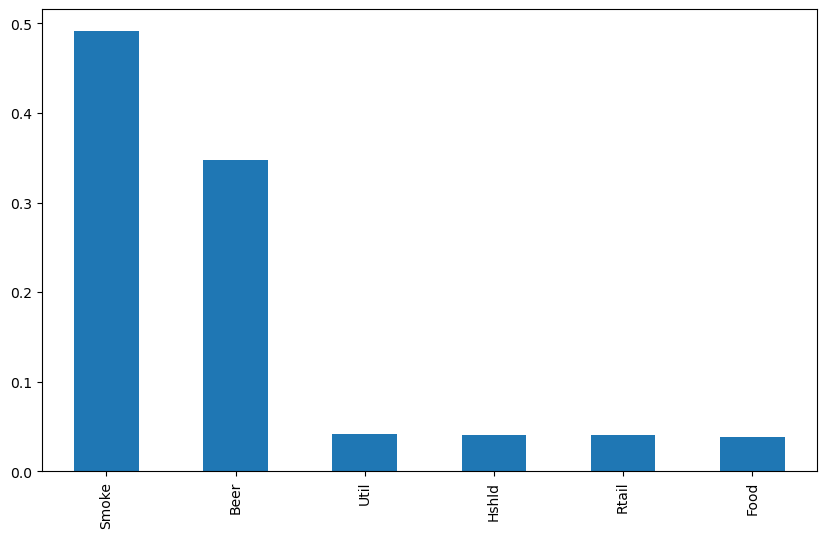

In [12]:
weights.sort_values(ascending=False).head(6).plot.bar();

By doing a reverse engineering we see the results are accurate!
Still we get some spurious results.
Contrast this to the results of a regression. Because the model is in fact very true (i.e. we really did construct the manager's returns out of the building blocks), the results are remarkably accurate. However, the negative coefficients are hard to intepret and in real-life data, those will be much larger. However when it works well, such as in this artificial example here, the results can be very accurate.

In [13]:
coeffs = m.regress(mgr_r, ind).params*100
coeffs.sort_values().head()

Hlth    -3.518837
Oil     -3.112282
Txtls   -2.917536
Trans   -2.845005
Telcm   -2.841669
dtype: float64

<Axes: >

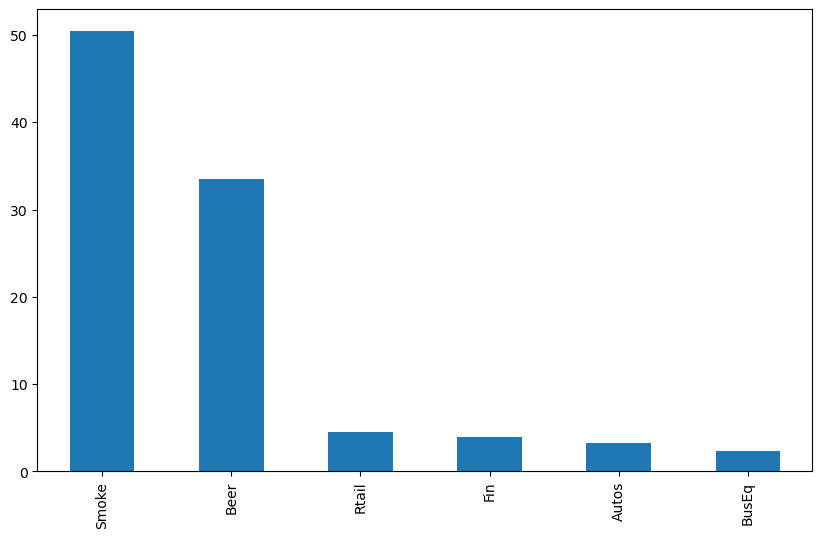

In [14]:
coeffs.sort_values(ascending=False).head(6).plot.bar()

# Warning: Potential Misuse of Style Analysis

Style Analysis works best when the explanatory indices are in fact a good specification of what is happening. For instance, it usually gives you very useful and revealing insight if you use a stock market index (such as SPY) and other broad indices, ETFs or mutual funds (such as a Value Fund, a Growth Fund, an International Fund, a Bond Fund etc).

Part of the skill in extracting meaningful results is to pick the right set of explanatory variables.

However, a part of the challenge with Style Analysis is that it will _always_ return a portfolio. Although it is possible to develop a figure of merit of fit quality similar to an $R^2$, it will still always give you an answer, however unreasonable it might be, and it's not always obvious how much one can rely on the result.

For instance, we can try and extract the major industries that Buffer invested in since 2000 as follows:

In [15]:
brka_m = pd.read_csv("brka_m.csv", index_col=0, parse_dates=True).to_period('M')

In [16]:
mgr_r_b = brka_m["2000":]["BRKA"]
weights_b = m.style_analysis(mgr_r_b, ind)
weights_b.sort_values(ascending=False).head(6).round(4)*100

Food    41.350000
Fin     17.610000
Meals   12.110000
Other   11.030000
Util     7.190000
Clths    5.990000
dtype: float64

In [17]:
brk2009 = brka_m["2009":]["BRKA"]
ind2009 = ind["2009":]
m.style_analysis(brk2009, ind2009).sort_values(ascending=False).head(6).round(4)*100

Other   43.640000
Food    28.330000
Hlth    22.720000
Rtail    5.250000
Meals    0.070000
Hshld    0.000000
dtype: float64

Should you believe the analysis? Probably not. However, when the specification is in fact accurate (as we saw in the articially generated series) the results can be very revealing

# Comparing EW and CapWeighted Portfolios


In [18]:
ind_cw = get_ind_returns(ew=False)
ind_ew = get_ind_returns(ew=True)

In [19]:
sr = pd.DataFrame({"CW": m.sharpe_ratio(ind_cw["1945":], 0.03, 12), \
                   "EW": m.sharpe_ratio(ind_ew["1945":], 0.03, 12)})

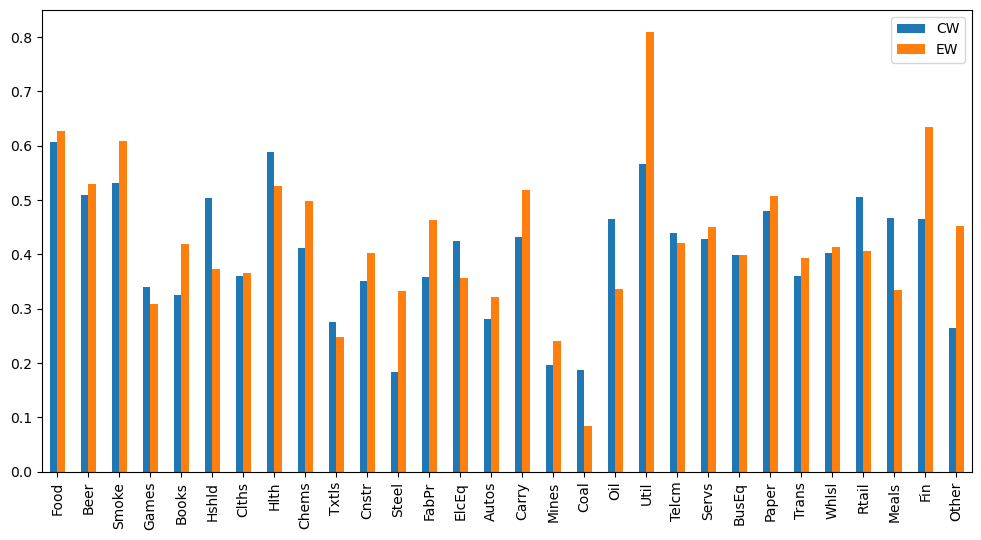

In [20]:
sr.plot.bar(figsize=(12, 6));

In [21]:
(sr["EW"] > sr["CW"]).sum()/sr.shape[0]*100

63.33333333333333

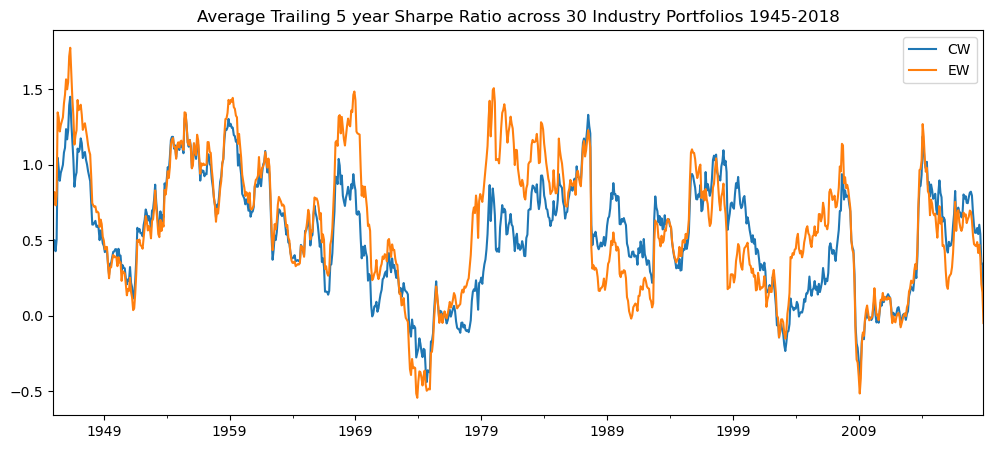

In [22]:
ax = ind_cw.rolling(60).apply(m.sharpe_ratio, raw=True, kwargs={"riskfree_rate":0.03, "periods_per_year":12})\
    .mean(axis=1)["1945":].plot(figsize=(12,5), label="CW", legend=True)
ind_ew.rolling(60).apply(m.sharpe_ratio, raw=True, kwargs={"riskfree_rate":0.03, "periods_per_year":12})\
    .mean(axis=1)["1945":].plot(ax=ax, label="EW", legend=True)
ax.set_title("Average Trailing 5 year Sharpe Ratio across 30 Industry Portfolios 1945-2018");

# Backtesting: EW vs CW

In [23]:
# in this contex value weighted portoflio is equity-value (ev)
# is equal to cap-weighted portfolio (cw)
ind49_rets = get_ind_returns2(weighting="vw", n_inds=49)["1974":]
ind49_mcap = get_ind_market_caps(49, weights=True)["1974":]

In this section we'll develop a basic infrastructure to backtest various portfolio construction techniques and compare them. Here we'll start with something quite simple and straightforward - we'll write trivially simple weight-optimizers for Equally Weighted and Cap Weighted portfolios and compare them. Obviously, there are no Covariance estimates required for either one of these weighting schemes. In following sessions we'll enhance these optimizers to use more complex weighting schemes that will rely on covariance estimates.

In [24]:
ewr= m.backtest_ws(r=ind49_rets, weighting=weight_ew)

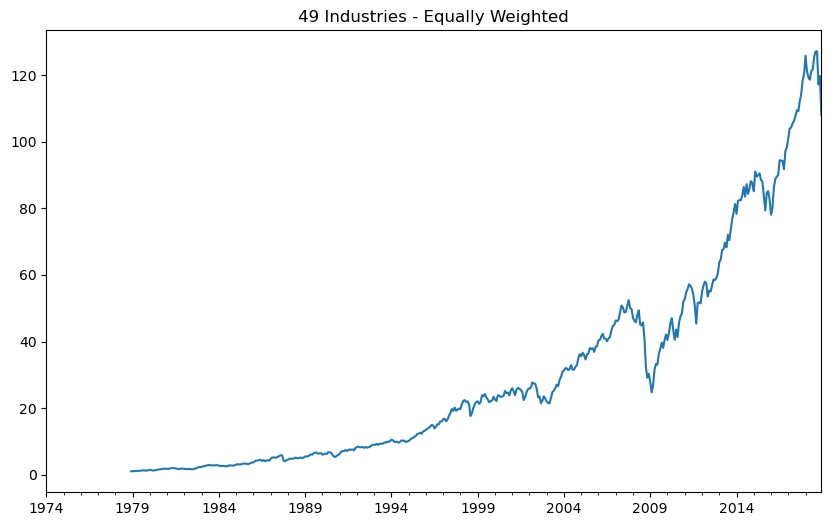

In [25]:
(1+ewr).cumprod().plot(title="49 Industries - Equally Weighted");

In [26]:
ewr = m.backtest_ws(r=ind49_rets, weighting=weight_ew)
cwr = m.backtest_ws(r=ind49_rets, weighting=weight_cw, cap_weights=ind49_mcap)

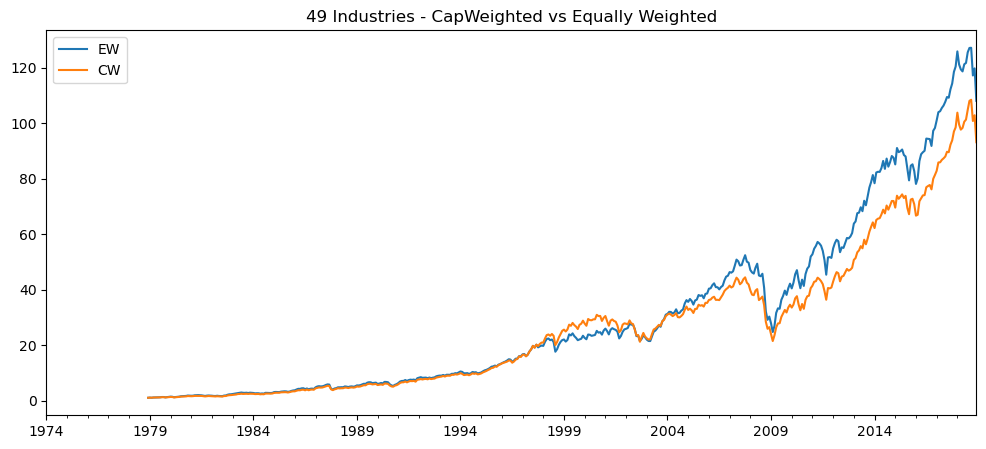

In [33]:
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,5), \
                       title="49 Industries - CapWeighted vs Equally Weighted");


In [34]:
m.summary_stats(btr.dropna())

,Ann. Return,Ann. Volatility,Skewness,Kurtosis,Corn-Fisher VaR (5%),Hist. CVar (5%),Sharpe Ratio,Max Drawdown
EW,0.123921,0.160660,-0.759092,6.659028,0.071404,0.102331,0.568799,-0.528292
CW,0.119761,0.147661,-0.726933,5.621768,0.065773,0.093909,0.591491,-0.516647


# Improving EW with CapWeight Tethering

Often in practice, we'll want to implement some sort of a modification of a pure strategy. For instance, although Equal Weight portfolios are popular, they'll be constrained in some way - for instance to match the sector weights of the cap-weighted benchmark or to make sure that microcap stocks are not overweighted. The motivation for doing so could be to make a portfolio more tradeable (e.g. some microcaps may not have the liquidity) or to improve the tracking error to the Cap-Weighted index.

As an illustration of how that can be achieved, we enhance our simple `weight_ew` allocator to (i) drop microcap stocks beyond a particular threshold, and (ii) impose a constraint that ensures that the maximum weight assigned to any stock is no more than some multiple of the weight it would be in a cap-weighted portfolio.

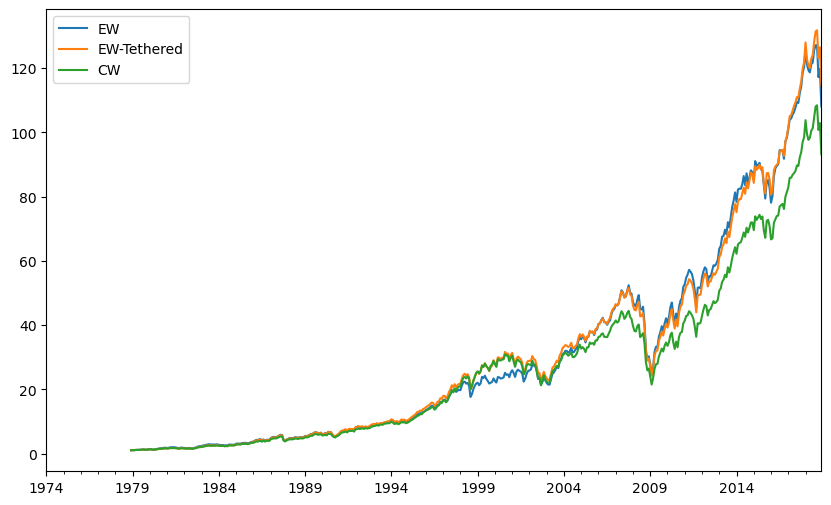

In [39]:
ewr = m.backtest_ws(r=ind49_rets, weighting=weight_ew)
ewtr = m.backtest_ws(r=ind49_rets, weighting=weight_ew_cap_teth, \
                     cap_weights=ind49_mcap, max_cw_mult=5, microcap_threshold=.005)
cwr =  m.backtest_ws(r=ind49_rets, weighting=weight_cw, cap_weights=ind49_mcap)
btr = pd.DataFrame({"EW": ewr, "EW-Tethered": ewtr, "CW": cwr})
(1+btr).cumprod().plot();

In [40]:
m.summary_stats(btr.dropna())

,Ann. Return,Ann. Volatility,Skewness,Kurtosis,Corn-Fisher VaR (5%),Hist. CVar (5%),Sharpe Ratio,Max Drawdown
EW,0.123921,0.160660,-0.759092,6.659028,0.071404,0.102331,0.568799,-0.528292
EW-Tethered,0.125572,0.156923,-0.752967,6.187433,0.069778,0.099191,0.592597,-0.530654
CW,0.119761,0.147661,-0.726933,5.621768,0.065773,0.093909,0.591491,-0.516647


In [41]:
# the real realson for doing EW Cap-Tethering is the reduction in the tracking error
m.tracking_error(ewr, cwr), m.tracking_error(ewtr, cwr)

(0.23248147494738436, 0.1553623086424526)